# Gradient based Optimisation 

In Machine learning, often you will be optimising algorithms to improve the performance of the algorithm. In architechtures such as neural-networks, the weights of the network are *parameters* that can be varied in order to minimise some *loss* function. 

You will see many examples of optimisation and these days there are some extremely sophisticated methods for optimising complicated loss functions, however in this notebook we'll go over the most common starting point for these which is *gradient based optimisation*. 

In statistics, as we've seen in the lectures, the *likelihood* (or negative log-likelihood) function is our loss function and we often need to maximise (minimise) it with respect to one or more of its parameters. 

In general, this means we're looking for the set of parameter values ($\theta$) for which, 

$$
\frac{\partial q}{\partial \theta}= 0
$$

where $q = -\log(L)$

There are two algorithms that use the gradient of the likelihood to find the maximum point that we'll go over in this notebook. 

## Newton method

You are probably very familar with the Newton method (from school even?), which relies on the gradient of the function to find roots (or zeros) of the function. In our setup, since we are trying to find the zeros of the gradient function, we'll also need to know the 2nd derivative. 

This method is very reliable for 1-dimensional problems (one parameter that is being maximised). The way this works is that from some initial starting point $\theta_{0}$, the algorithm proposes the next step as, 

$$
\theta_{1} = \theta_{0} - \frac{q^{\prime}(\theta_{0})}{q^{\prime\prime}(\theta_{0})}
$$

where $q^{\prime} = \frac{dq}{d\theta}$, and $q^{\prime\prime} = \frac{d^{2}q}{d\theta^{2}}$.

The algorithm continues until some tolerance is reached, $\lvert q^{\prime}\rvert < \delta$ where $\delta$ is some small number greater than 0. 

We'll take a look at an example of this method where we have a unstable particle (let's say a muon) that decays after being produced in a particle collision. In these processes, the probability that the muon decays after a certain time depends on its lifetime ($\tau$),  

Suppose we had an experimental setup, capable of detecting when such decays were occuring and we marked down the times, after some $t_{0}$, that each decay occurs. The time of each decay will be a random variable and will be distributed according to an exponential decay function, 

$$
p(t) = \frac{1}{\tau} e^{-t/\tau}
$$

First, we'll grab some data to use for this. I've put some data in a `.csv` file. From this data, we want to find the value of $\tau$ that minimises the negative log-likelihood for this data. 

In [1]:
%matplotlib inline

import math
import numpy
import matplotlib.pyplot as plt

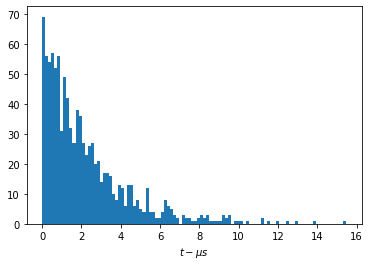

In [2]:
import pandas 
data_exp = pandas.read_csv("decay_data.csv")

plt.hist(data_exp["times"],bins=100)
plt.xlabel("$t - \mu s$")
plt.show()

data_exp = numpy.array(data_exp["times"].to_list())

The likelihood is just the product over all of the muon decay times, 

$$
L(\tau) = \prod_{i} \frac{1}{\tau} e^{-t_{i}/\tau}
$$

and the -ve log likelihood is, 

$$
q = -\ln(L) =  N\ln (\tau) + \sum_{i}^{N} \frac{t_{i}}{\tau}  
$$

In [3]:
# define -ve log-likelihood
def q(data,tau):
 N = len(data)
 return N*math.log(tau) + sum(data)/tau

Let's see how the value of $q(\tau)$ changes as we change the value of $\tau$. Use the slider to see how changing the slope of the curve (the parameter $\tau$) changes the value of $q$. 

In [4]:
import ipywidgets

xrange = numpy.linspace(0,16,100)

def pdf(x,tau):
    return (1./tau)*numpy.exp(-x/tau)

def plot_likelihood(tau):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    ax1.hist(data_exp,bins=100,histtype='step',color='black',density='true')
    ax1.plot(xrange,pdf(xrange,tau),color='red')
    ax1.set_xlabel("$t - \mu s$")
    ax1.set_ylim(0,0.6)
    
    ax2.plot([tau],[q(data_exp,tau)],color='red',marker='o')
    ax2.set_ylim(1750,1900)
    ax2.set_xlim(1,4)
    ax2.set_xlabel("$\\tau$")
    ax2.set_ylabel("$q(\\tau)$")
    ax2.grid()

ipywidgets.interact(plot_likelihood,tau=(0,4,0.1))


interactive(children=(FloatSlider(value=2.0, description='tau', max=4.0), Output()), _dom_classes=('widget-int…

<function __main__.plot_likelihood(tau)>

We can make a simple static plot of this too

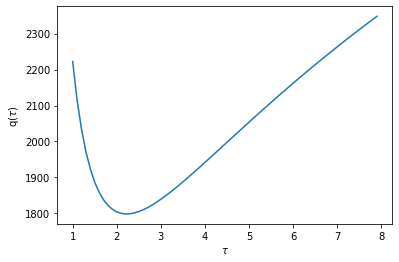

In [5]:
x = numpy.arange(1,8,0.1)
y = [q(data_exp,xx) for xx in x]

plt.plot(x,y)
plt.xlabel("$\\tau$")
plt.ylabel("q($\\tau$)")
plt.show()

Now lets look for the minimum of this curve by finding value of $\tau$ for which $q^{\prime}=0$ using the Newton method. 

We need to write down the derivatives of $q$.

$$
q^{\prime} = \frac{N}{\tau}  -\frac{1}{\tau^{2}}\sum_{i}^{N} t_{i} 
$$

$$
q^{\prime\prime} = -\frac{N}{\tau^{2}} + \frac{2}{\tau^{3}}\sum_{i}^{N} t_{i} 
$$

In [6]:
# define the derivative of the -ve log-likelihood
def dq(data, tau):
 N = len(data)
 return N/tau - sum(data)/(tau*tau)

# define thei second derivative of the -ve log-likelihood
def d2q(data, tau):
 N = len(data)
 return -N/(tau*tau) + 2*sum(data)/(tau*tau*tau)

We start by initialising the algorithm and setting a tolerance for when to stop searching.

In [7]:
# numerical minimum
tol = 0.01
init_tau = 3
eps = 100

# keep a record of the steps
steps = []

while eps > tol:
 steps.append([init_tau,q(data_exp,init_tau)])
 qp = dq(data_exp,init_tau)
 eps = abs(qp)
 init_tau = init_tau - qp/d2q(data_exp,init_tau)
 if init_tau < 0 : init_tau = 0.1
 

numerical_min = init_tau
print("minimum at tau = ",numerical_min, "microseconds")
print("took %d steps"%len(steps))

minimum at tau =  2.222246828655853 microseconds
took 7 steps


![Optimise](explh.gif)

The muon lifetime is known to be $\sim 2.2 \mu s$. This is actually an  example of a maximum likelihood estimate for the muon lifetime. 

## Gradient descent 

For functions with more than one variable, we  can use a gradient descent algorithm to find minima and maxima. These methods only rely on the first derivative (the gradient) to find the best direction to step in to find the minimum (or maximum). They don't use the second derivative because for a large number of parameters $n$, the number of terms in the second derivative grows as $n^{2}$ so this can get quite costly. 

There are  a number of subtle different algorithms which rely on gradient descent but we'll go over a simple example. The  way this works is as follows. 

First, we initialise the algorithm at some set of values for the parameters $\boldsymbol{\theta}_{init}$. Then we calcualte the gradient of the negative log-likelihood - $\nabla(q)\rvert_{\boldsymbol{\theta}_{init}}$ - at that initial point. The gradient defines a direction in which the negative log-likelihood changes most rapidly - this makes this direction a good direction to search for a smaller value of $q$.

$$
\begin{align}
\nabla(q)\rvert_{\boldsymbol{\theta}_{init}} &=   
        \begin{bmatrix}
           \frac{\partial q}{\partial \theta_{1}} \\
           \frac{\partial q}{\partial \theta_{2}} \\
           \vdots \\
           \frac{\partial q}{\partial \theta_{n}}
        \end{bmatrix}_{\boldsymbol{\theta}=\boldsymbol{\theta}_{init}}
\end{align}   
$$

Since we want to *decrease* $q$, we need to move against this gradient. We step along the negative gradient direction until we find a new minimum - i.e we pick a step size $h$ and keep adding it to the initial point until the value of $q$ stops decreasing, 


$$
\boldsymbol{\theta}_{k} = k\times h - \nabla(q)\rvert_{\boldsymbol{\theta}_{init}} 
$$

At the value of $k$ such that we're no longer decreasing $q$ (lets call it $k*$), we recalculate the gradient and find a new direction to go in. 

$$
\nabla(q)\rvert_{\boldsymbol{\theta}_{k*}}
$$

We keep repeating this process until the modulus of the gradient gets close enough to zero (say is smaller than some tolerance $\epsilon$, that means we keep iterating until, 

$$
\lvert \nabla(q)\rvert_{\boldsymbol{\theta}} \rvert = \sqrt{\left(\frac{\partial q}{\partial \theta_{1}}\right)^{2} + \left(\frac{\partial q}{\partial \theta_{2}}\right)^{2}+...+\left(\frac{\partial q}{\partial \theta_{n}}\right)^{2}}< \epsilon
$$

Let's look at an example where $n=2$ and the data is assumed to be distributed as a Gaussian with parameters $\mu$ and $\sigma$. We want to find the maximum likelihood estimates $\hat{\mu}$ and $\hat{\sigma}$. 

We'll read in some data from the file `data_grad_desc.csv`. 

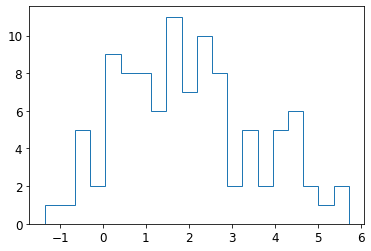

In [8]:
import numpy,pandas
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from scipy.stats import norm
data = pandas.read_csv("data_grad_desc.csv")
data = data['values'].to_numpy()
plt.hist(data,bins=20,histtype='step')
plt.show()

Let's see how different values of the Gaussian parameters $\mu$ and $\sigma$ compare when plotted on top of the data, this timee as a histogram of the density.

In [16]:
from scipy.stats import norm 
xrange = numpy.linspace(-2,6,100)

def plot_gaussian(mu,sigma):
    
    plt.hist(data,bins=20,histtype='step',density=True)
    plt.plot(xrange,norm.pdf(xrange,mu,sigma),color='red')
    plt.xlabel("$X$")
    plt.ylim(0,0.4)


ipywidgets.interact(plot_gaussian,mu=(1,3,0.1),sigma=(0.5,3,0.1))

interactive(children=(FloatSlider(value=2.0, description='mu', max=3.0, min=1.0), FloatSlider(value=1.70000000…

<function __main__.plot_gaussian(mu, sigma)>

Next we can define the negative log-likelihood and plot it as a function of $\mu$ and $\sigma$. Remember, the likelihood is just the product over the Gaussian probability density for each value in our dataset. 

The negative log-likelihood in this case is going to be (it's easy to show it) a sum over terms for all 101 points in our dataset. 

$$
q(\mu,\sigma) = -\ln(L(\mu,\sigma)) = \sum_{i=1}^{101} \left[ \ln(\sigma\sqrt{2\pi}) + \frac{1}{2}\frac{\left(X_{i}-\mu\right)^{2}}{\sigma^{2}} \right]
$$

I've also subtracted the smallest value of the negative log-likelihood so that the numbers we have to deal with are more reasonable (of course this won't change where the minimum is). 

Text(0, 0.5, '$\\sigma$')

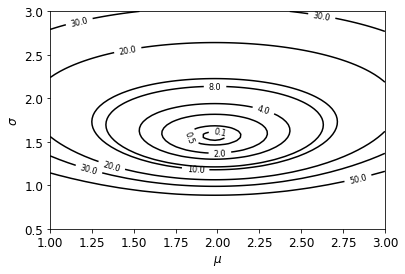

In [9]:
sqrt2pi = (2*numpy.pi)**0.5 

def neg_log_likelihood(point):
    mean=point[0]
    sigma=point[1]
    return sum([numpy.log(sqrt2pi*sigma) + 0.5*(x-mean)*(x-mean)/(sigma*sigma) for x in data])
    
def sum_neg_log_likelihood(mean,sigma):
    return neg_log_likelihood([mean,sigma])

mu    = numpy.linspace(1, 3, 70)
sigma = numpy.linspace(0.5, 3, 70)

X,Y = numpy.meshgrid(mu,sigma)

logL = sum_neg_log_likelihood(X,Y)
# These are large numbers so subtract the smallest one 
logL = logL-logL.min()

contours = plt.contour(X, Y, logL, colors='black',levels=[0.1,0.5,2,4,8,10,20,30,50])
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")

Next we define the gradient and run through our optimisation. Each step is given by the function `gradient_optimise_step` and it returns a new point and the magnitude of the gradient at that point. 

In [10]:
def grad_nll(point):
    mean = point[0]
    sigma = point[1]
    ddmu    = sum([mean/(sigma*sigma) - x/(sigma*sigma) for x in data])
    ddsigma = sum([1./sigma - (1./(sigma*sigma*sigma))*(x-mean)*(x-mean) for x in data])
    return numpy.array([ddmu,ddsigma])

def modulus(point):
    return (point[0]**2+point[1]**2)**0.5

# inititial point -> mu=1.25, sigma=2.5
init = numpy.array([1.25,2.5])
grad_size = modulus(grad_nll(init))

def gradient_optimise_step(init):

  # 1. find the gradient at this point 
  vec = grad_nll(init)

  # 2. Do a very quick line search to find where the minimum is along the line (pick step size of 0.001)
  min_nll = neg_log_likelihood(init)
  start = init  

  for i in range(10):
    new_point = start-0.001*vec
    new_nll   = neg_log_likelihood(new_point)
    if new_nll < min_nll:
      min_nll =  new_nll
      start = new_point
      #print(" line search -> ", new_point,new_nll)
    else: break      
  return new_point, modulus(grad_nll(new_point))

step = []
step.append(init)
while grad_size > 1:
  new,grad_size = gradient_optimise_step(init)
  init = new 
  step.append(init)

print("Minimum found at - ",init)

Minimum found at -  [1.96835639 1.56718272]


![Grad](grad.gif)

Of course, we don't need to write optimisation routines ourselves since there's many good packages out there that have done this for us. For the rest of this course, we'll use the `scipy` and `iminuit` packages for optimisation problems. 